In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
import torchtext as tt
import spacy
import time
from datetime import datetime
import re

In [ ]:
# uncomment below line if package hasn't been downloaded yet (error will show module "en_core_web_sm" not found)
# !python -m spacy download en_core_web_sm


dtype = torch.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
sentences = ''
corpus_size = 2000
play = False

In [ ]:
# to prevent reuters to be generated right after eg. washington because every article starts with "[location] - reuters ..."
def filter_reuters(txt):
    idx = txt.index('-')
    return txt[idx+1:].strip()

start_time = datetime.fromtimestamp(time.time())
print(f'<{start_time}> training started on {device}')

In [54]:


if play:
    sentences = [ "i like dog", "i like cat", "i like animal", 
              "dog cat animal", "apple cat dog like", "dog fish milk like",
              "dog cat eyes like", "i like apple", "apple i hate",
              "apple i movie", "book music like", "cat dog hate", "cat dog like"]
else:
    df = pd.read_csv("./data/True.csv")
    nlp = spacy.load('en_core_web_sm')
    tokenizer = tt.data.utils.get_tokenizer('spacy')
    np_array = df['text'].values
    txt_array = np_array.tolist()[0:corpus_size]
    txt_array = [filter_reuters(txt) for txt in txt_array]
    sentences = '\n'.join(txt_array)
    sentences = sentences.lower()

number_match = re.compile('\b.*[0-9].*\b')
punctuation_match = re.compile('\b.*(\.|\\|\/|,\/|\(|\)).*\b')


print(sentences[0:100])
for sentence in sentences:
    sentence = number_match.sub(repl="", string=sentence)
    sentence = punctuation_match.sub(repl="", string=sentence)

print(sentences[0:100])
print(f'number of articles: {len(txt_array)}')
print(f'length of sentences: {len(sentences)}')


# list all the words present in our corpus
word_sequence = tokenizer(sentences)
word_list = list(set(word_sequence))

print(f'{len(word_list)} unique tokens')

# word_list = [word for word in word_list if not number_match.match(word)]
# print(f'{len(word_list)} unique tokens after removing numbers')
# word_list = [word for word in word_list if not punctuation_match.match(word)]
# print(f'{len(word_list)} unique tokens after removing special characters')


# print(word_sequence)
# build the vocabulary
print(f'final length of word list: {len(word_list)}')
word_dict = {w: i for i, w in enumerate(word_list)}

# print(word_dict)

# Word2Vec Parameter
batch_size = 5  # To show 2 dim embedding graph
embedding_size = 2  # To show 2 dim embedding graph
voc_size = len(word_list)

<2023-05-25 13:55:56.145014> training started on cuda


d:\dev\bachelor\deep_learning\env_test\.venv\lib\site-packages\torchtext\data\utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


the head of a conservative republican faction in the u.s. congress, who voted this month for a huge 
the head of a conservative republican faction in the u.s. congress, who voted this month for a huge 
number of articles: 2000
length of sentences: 4752429
21319 unique tokens
final length of word list: 21319


In [42]:
# input word
# j = 1
# print("Input word : ")
# print(word_sequence[j], word_dict[word_sequence[j]])

# context words
# print("Context words : ")
# print(word_sequence[j - 1], word_sequence[j + 1])
# print([word_dict[word_sequence[j - 1]], word_dict[word_sequence[j + 1]]])

In [55]:
# Make skip gram of one size window
window_size = 2
skip_grams = []
for i in range(1, len(word_sequence) - window_size):
    input = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - window_size]], word_dict[word_sequence[i + window_size]]]
    for w in context:
        skip_grams.append([input, w])


#lets plot some data
# skip_grams[:6]

In [56]:
np.random.seed(172)

def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        # one-hot encoding of words
        random_inputs.append(np.eye(voc_size)[data[i][0]])  # input
        random_labels.append(data[i][1])  # context word

    return random_inputs, random_labels

# random_batch(skip_grams[:6], size=3)

# inputs: like , i, dog , context: i, dog, i

In [57]:
# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()

        # parameters between -1 and + 1
        self.W = nn.Parameter(-2 * torch.rand(voc_size, embedding_size) + 1).type(dtype).to(device) # voc_size -> embedding_size Weight
        self.V = nn.Parameter(-2 * torch.rand(embedding_size, voc_size) + 1).type(dtype).to(device) # embedding_size -> voc_size Weight
        
        self.params = nn.ParameterList([self.W, self.V])

    def forward(self, X):
        hidden_layer = torch.matmul(X, self.params[0]) # hidden_layer : [batch_size, embedding_size]
        output_layer = torch.matmul(hidden_layer, self.params[1]) # output_layer : [batch_size, voc_size]
        #return output_layer 
        return output_layer

model = Word2Vec()
# Set the model in train mode
model.train()

criterion = nn.CrossEntropyLoss() # Softmax (for multi-class classification problems) is already included

optimizer = optim.Adam(params=model.params, lr=0.001)

In [46]:
# Training
epochs = 10000
print_freq = (epochs // 10) or 1
all_losses = []
avg_loss = 0
for epoch in range(epochs):
    input_batch, target_batch = random_batch(skip_grams, batch_size)

    # new_tensor(data, dtype=None, device=None, requires_grad=False)
    input_batch = torch.Tensor(input_batch).to(device)
    target_batch = torch.LongTensor(target_batch).to(device)

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    avg_loss += loss.item()
    if (epoch + 1)%print_freq == 0:
        epoch_time = datetime.fromtimestamp(time.time())
        # print('<', epoch_time, '> Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
        all_losses.append(avg_loss / print_freq)
        avg_loss = 0

    loss.backward()
    optimizer.step()
time_done = datetime.fromtimestamp(time.time())
print('<', time_done, '> Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

< 2023-05-25 11:44:40.772116 > Epoch: 10000 cost = 8.522721


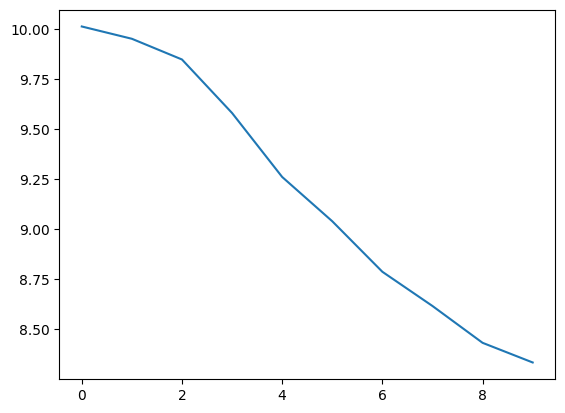

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline


# print(all_losses)
# matplotlib couldn't plot cuda tensors
# first copy to host memory by loss.cpu() - then detach and to np array
# losses_to_plot = [loss.cpu().detach().numpy() for loss in all_losses]
# print(losses_to_plot)
plt.figure()
plt.plot(all_losses)

In [48]:
# Learned W
W, _= model.parameters()
print(W.detach())

tensor([[ 0.4196,  0.1013],
        [ 0.6157,  0.6807],
        [ 1.1526,  0.7145],
        ...,
        [ 0.3505, -0.6393],
        [-0.3730,  0.6283],
        [ 0.8739,  0.7780]], device='cuda:0')


In [49]:
file_path = f'./models/w2v_wsize_{window_size}_epocs_{epochs}.model'
torch.save(model.state_dict(), file_path)

end_time = datetime.fromtimestamp(time.time())
print(f'training finished at: {end_time}')

training finished at: 2023-05-25 11:44:41.007086


In [50]:
# for i, word in enumerate(word_list):
#     W, _= model.parameters()
#     W = W.detach()
#     x,y = float(W[i][0]), float(W[i][1])
#     plt.scatter(x, y)
#     plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
# plt.show()

In [84]:
import pickle
W, _ = model.parameters()
W = W.detach()
w2v = {}
v2w = {}

for i, word in enumerate(word_list):
    W, _= model.parameters()
    W = W.detach()
    x,y = float(W[i][0]), float(W[i][1])
    w2v[word]=(x,y)
    v2w[(x,y)]=word

print(f'vocabulary size: {len(word_list)}')

print(w2v['process'])

with open('./models/w2v.dat', 'wb') as f_path:
    pickle.dump(w2v, f_path)

with open('./models/v2w.dat', 'wb') as f_path:
    pickle.dump(v2w, f_path)



vocabulary size: 21319
(-0.4104248285293579, 0.6316843032836914)


In [87]:
lookup_w2v = {}
lookup_v2w = {}

with open('./models/w2v.dat', 'rb') as f_path:
    lookup_w2v = pickle.load(f_path)
    

with open('./models/v2w.dat', 'rb') as f_path:
    lookup_v2w = pickle.load(f_path)
    
x,y = lookup_w2v['trump']
trump = lookup_v2w[(x,y)]
print(trump)

# for k,v in lookup_v2w.items():
#     print(f"key: {k} value: {v}")


trump
